In [1]:
# ─────────────────────────────────────────────────────────────────────────
# Cell 1: Mount Drive & Imports
# ─────────────────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)

# Paths — adjust these!
H5_PATH    = "/content/drive/MyDrive/new_volumes.h5"
CKPT_PATH  = "/content/drive/MyDrive/PDAC_models/resnet18_best.pth"


Mounted at /content/drive
Running on cpu


In [2]:
# ─────────────────────────────────────────────────────────────────────────
# Cell 2: Volume Dataset + DataLoader
# ─────────────────────────────────────────────────────────────────────────
class H5VolumeDataset(Dataset):
    def __init__(self, h5_path, split="val", test_size=0.2, random_state=42, max_slices=64):
        # read all pids & labels
        with h5py.File(h5_path, "r") as hf:
            self.pids   = list(hf["volumes"].keys())
            labels      = [int(hf["volumes"][pid].attrs["label"]) for pid in self.pids]
        # train/val split
        from sklearn.model_selection import train_test_split
        train, val = train_test_split(
            self.pids, test_size=test_size, stratify=labels, random_state=random_state
        )
        self.pids = val if split=="val" else train
        self.h5_path    = h5_path
        self.max_slices = max_slices

    def __len__(self):
        return len(self.pids)

    def __getitem__(self, idx):
        pid = self.pids[idx]
        with h5py.File(self.h5_path, "r") as hf:
            grp    = hf["volumes"][pid]
            vol_np = grp["images"][:]             # numpy [N,2,H,W]
            label  = int(grp.attrs["label"])
        # cap number of slices
        N, C, H, W = vol_np.shape
        if N > self.max_slices:
            indices = np.linspace(0, N-1, self.max_slices, dtype=int)
            vol_np  = vol_np[indices]
        vol = torch.from_numpy(vol_np).float().div(255.0)  # [n,2,H,W]
        return vol, label

def collate_fn(batch):
    vols, labs = zip(*batch)
    max_n = max(v.shape[0] for v in vols)
    padded = []
    for v in vols:
        n, c, h, w = v.shape
        if n < max_n:
            pad = torch.zeros((max_n-n, c, h, w), dtype=v.dtype)
            v = torch.cat([v, pad], dim=0)
        padded.append(v)
    return torch.stack(padded), torch.tensor(labs)

val_ds = H5VolumeDataset(H5_PATH, split="val", max_slices=64)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False,
    num_workers=0, pin_memory=False, collate_fn=collate_fn
)

print("Validation volumes:", len(val_ds))


Validation volumes: 114


In [3]:
# ─────────────────────────────────────────────────────────────────────────
# Cell 3: Model Definition & Load Checkpoint
# ─────────────────────────────────────────────────────────────────────────
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class MILResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.feat = nn.Sequential(
            backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool,
            backbone.layer1, backbone.layer2,
            backbone.layer3, backbone.layer4,
            backbone.avgpool
        )
        self.cls = nn.Linear(512, 2)

    def forward(self, x):
        B, N, _, H, W = x.shape
        x = x.view(B*N, 2, H, W)
        f = self.feat(x).view(B, N, 512)
        bag, _ = f.max(dim=1)
        return self.cls(bag)

model = MILResNet18().to(DEVICE)
state = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()
print("Loaded checkpoint from", CKPT_PATH)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


Loaded checkpoint from /content/drive/MyDrive/PDAC_models/resnet18_best.pth


→ Val AUC: 0.655   Acc: 0.579

Confusion Matrix:
 [[50 31]
 [17 16]]

Classification Report:
               precision    recall  f1-score   support

     Control       0.75      0.62      0.68        81
        PDAC       0.34      0.48      0.40        33

    accuracy                           0.58       114
   macro avg       0.54      0.55      0.54       114
weighted avg       0.63      0.58      0.60       114



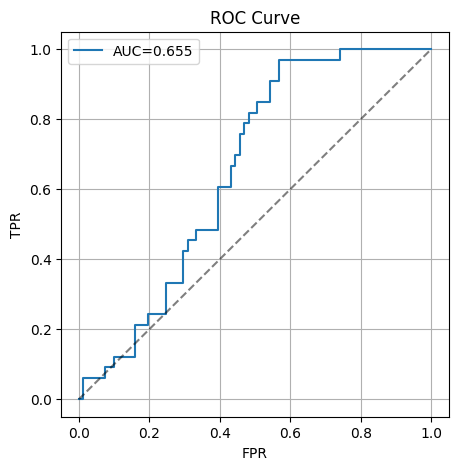

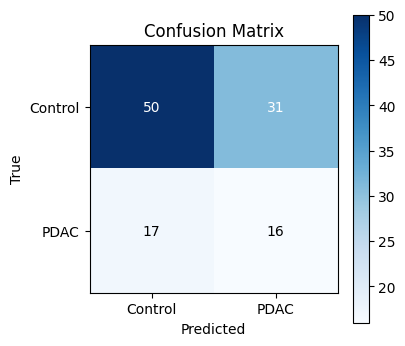

In [5]:
# ─────────────────────────────────────────────────────────────────────────
# Cell 4: Run Evaluation & Plot Metrics
# ─────────────────────────────────────────────────────────────────────────
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for vols, labs in val_loader:
        vols, labs = vols.to(DEVICE), labs.to(DEVICE)
        logits = model(vols)
        probs  = torch.softmax(logits, dim=1)[:,1]
        preds  = (probs > 0.5).long()
        y_true.extend(labs.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

y_true  = np.array(y_true)
y_pred  = np.array(y_pred)
y_score = np.array(y_score)

# Metrics
auc    = roc_auc_score(y_true, y_score)
acc    = accuracy_score(y_true, y_pred)
cm     = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Control","PDAC"])

print(f"→ Val AUC: {auc:.3f}   Acc: {acc:.3f}\n")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.grid()
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center",
                 color="white" if cm[i,j]>cm.max()/2 else "black")
plt.xticks([0,1], ["Control","PDAC"]); plt.yticks([0,1], ["Control","PDAC"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix"); plt.colorbar()
plt.show()


In [6]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    average_precision_score
)

# Assume y_true and y_score are already populated:
#   y_true = [0,1,0,1,…]
#   y_score = [0.12,0.78,0.34,0.65,…]

# Choose your decision threshold (default 0.5)
thr = 0.5
y_pred = [int(p >= thr) for p in y_score]

# Compute basic metrics
acc   = accuracy_score(y_true, y_pred)
auc   = roc_auc_score(y_true, y_score)
ap    = average_precision_score(y_true, y_score)
prec  = precision_score(y_true, y_pred)
rec   = recall_score(y_true, y_pred)
f1    = f1_score(y_true, y_pred)
cm    = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=['Control','PDAC'])

# Print everything
print("=== Evaluation Metrics ===")
print(f"Accuracy          : {acc:.4f}")
print(f"ROC AUC           : {auc:.4f}")
print(f"Average Precision : {ap:.4f}")
print(f"Precision (P=PDAC): {prec:.4f}")
print(f"Recall    (PDAC)  : {rec:.4f}")
print(f"F1‐score (PDAC)   : {f1:.4f}\n")

print("Confusion Matrix (rows=true, cols=pred):")
print(cm, "\n")

print("Classification Report:")
print(report)


=== Evaluation Metrics ===
Accuracy          : 0.5789
ROC AUC           : 0.6554
Average Precision : 0.3792
Precision (P=PDAC): 0.3404
Recall    (PDAC)  : 0.4848
F1‐score (PDAC)   : 0.4000

Confusion Matrix (rows=true, cols=pred):
[[50 31]
 [17 16]] 

Classification Report:
              precision    recall  f1-score   support

     Control       0.75      0.62      0.68        81
        PDAC       0.34      0.48      0.40        33

    accuracy                           0.58       114
   macro avg       0.54      0.55      0.54       114
weighted avg       0.63      0.58      0.60       114



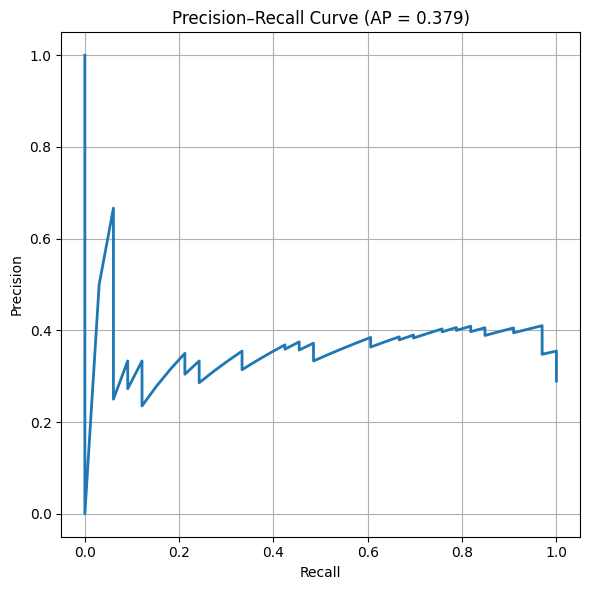

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision/recall
precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.grid(True)
plt.tight_layout()
plt.savefig("pr_curve.png", dpi=300)
plt.show()


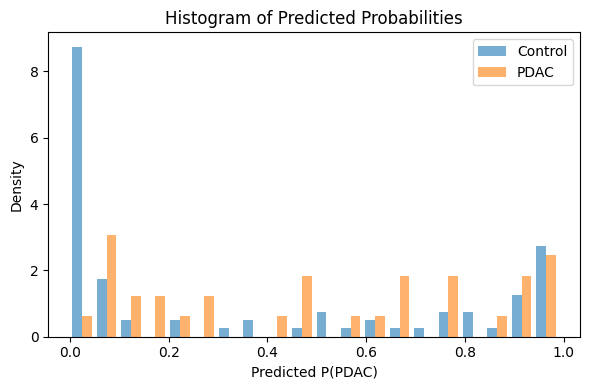

In [8]:
import matplotlib.pyplot as plt
import numpy as np

probs_pdac    = np.array(y_score)[np.array(y_true)==1]
probs_control = np.array(y_score)[np.array(y_true)==0]

plt.figure(figsize=(6,4))
plt.hist([probs_control, probs_pdac],
         bins=20, density=True, alpha=0.6,
         label=['Control','PDAC'])
plt.xlabel("Predicted P(PDAC)")
plt.ylabel("Density")
plt.title("Histogram of Predicted Probabilities")
plt.legend()
plt.tight_layout()
plt.savefig("prob_hist.png", dpi=300)
plt.show()


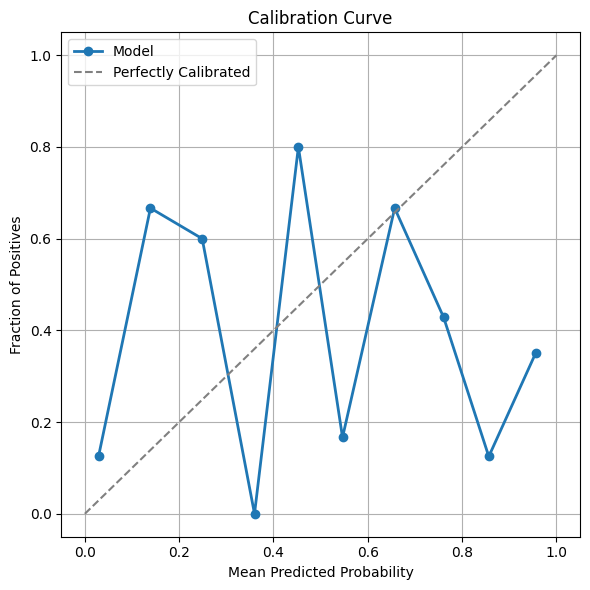

In [9]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Get fraction of positives vs predicted prob
prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', lw=2, label='Model')
plt.plot([0,1],[0,1], '--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("calibration_plot.png", dpi=300)
plt.show()
